(180,)
Reconstructing 8 slice groups with 8 master threads...


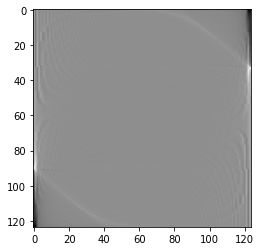

In [126]:
import tomopy
import numpy as np
obj = tomopy.shepp3d(size=124) # Generate an object.
ang = tomopy.angles(180) # Generate uniformly spaced tilt angles.
print(ang.shape)
sim = tomopy.project(obj, ang, pad = False) # Calculate projections.
#rec = tomopy.recon(sim, ang, algorithm='art')
rec = tomopy.recon(sim, ang, algorithm='art', num_gridx=124, num_gridy=124) # Reconstruct object.
#rec = tomopy.recon(np.expand_dims(sim[:,75,:],1), ang, algorithm='art') # Reconstruct object.

# Show 64th slice of the reconstructed object.
import matplotlib.pyplot as plt
plt.imshow(rec[0], cmap='gray')
plt.show()

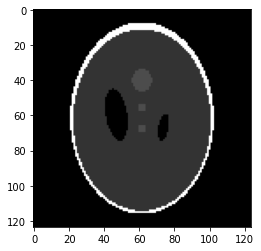

In [116]:
plt.imshow(obj[75], cmap='gray')
plt.show()

In [117]:
print('original shape', obj.shape)
print('slices shape', rec.shape)
print('sinogram shape', sim.shape)

original shape (124, 124, 124)
slices shape (124, 124, 124)
sinogram shape (180, 124, 124)


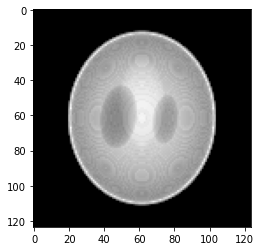

In [118]:
plt.imshow(sim[0], cmap='gray')
plt.show()

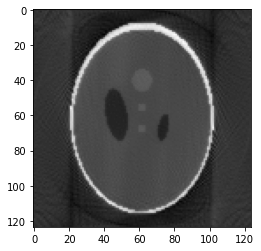

In [119]:
plt.imshow(rec[75], cmap='gray')
plt.show()

In [ ]:
sim2 = tomopy.project(rec, ang) # Calculate projections.
rec2 = tomopy.recon(sim2, ang, algorithm='art')
plt.imshow(rec2[75], cmap='gray')
plt.show()

In [ ]:
print(rec2.shape)

In [ ]:
plt.imshow(rec[30], cmap='gray')
plt.show()

In [ ]:
sim.shape

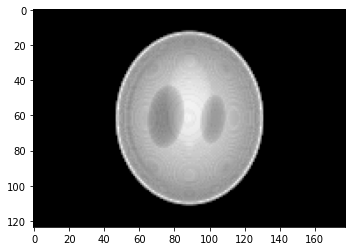

In [83]:
plt.imshow(sim[1], cmap='gray')
plt.show()

In [ ]:
plt.imshow(sim[9], cmap='gray')
plt.show()

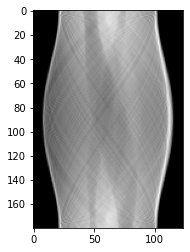

In [120]:
plt.imshow(sim[:,75,:], cmap='gray')
plt.show()

In [ ]:
rec.shape

In [8]:
import tensorflow as tf
import tensorflow_addons as tfa

In [167]:
import math

def diff_proj(img, ang):
    angles = tf.range(0, math.pi, math.pi / ang)
    img = tf.expand_dims(img, -1)
    images = tf.tile(tf.expand_dims(img, 0), [angles.shape[0], 1, 1, 1])
    rotated_img = tfa.image.rotate(
        images = images,
        angles = -angles,
        interpolation = 'bilinear',
        fill_mode = 'constant',
        #fill_value = 0.0
    )

    sin = tf.reduce_sum(rotated_img, axis=1)
    return sin

In [168]:
tf_proj_sim = diff_proj(obj[75], 180)
print(tf_proj_sim.shape)

(180, 124, 1)


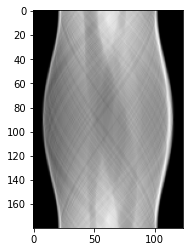

In [169]:
plt.imshow(tf_proj_sim, cmap='gray')
plt.show()

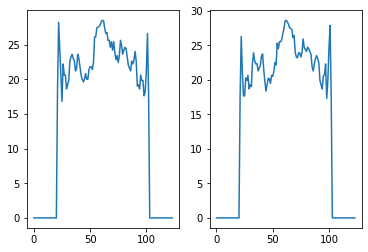

In [130]:
N = 5

fig = plt.figure()

fig.add_subplot(121)
plt.plot(tf_proj_sim[N,:,0])

fig.add_subplot(122)
plt.plot(sim[:,75,:][N,:])

plt.show()

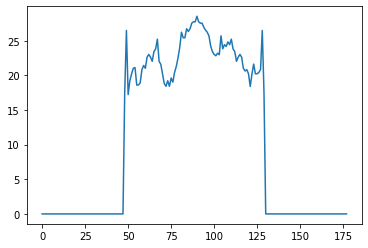

In [111]:
plt.plot(sim[:,75,:][3,:])
plt.show()

In [ ]:
def diff_proj(img, ang, theta):
    if theta is None:
        theta = np.arange(180)

    if circle:
        shape_min = tf.reduce_min(image.shape)
        radius = shape_min // 2
        img_shape = np.array(image.shape)
        coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]],
                          dtype=object)
        dist = ((coords - img_shape // 2) ** 2).sum(0)
        outside_reconstruction_circle = dist > radius ** 2
        if np.any(image[outside_reconstruction_circle]):
            warn('Radon transform: image must be zero outside the '
                 'reconstruction circle')
        # Crop image to make it square
        slices = tuple(slice(int(np.ceil(excess / 2)),
                             int(np.ceil(excess / 2) + shape_min))
                       if excess > 0 else slice(None)
                       for excess in (img_shape - shape_min))
        padded_image = image[slices]
    else:
        diagonal = np.sqrt(2) * max(image.shape)
        pad = [int(np.ceil(diagonal - s)) for s in image.shape]
        new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
        old_center = [s // 2 for s in image.shape]
        pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
        pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
        padded_image = np.pad(image, pad_width, mode='constant',
                              constant_values=0)

    # padded_image is always square
    if padded_image.shape[0] != padded_image.shape[1]:
        raise ValueError('padded_image must be a square')
    center = padded_image.shape[0] // 2
    radon_image = np.zeros((padded_image.shape[0], len(theta)),
                           dtype=image.dtype)

    for i, angle in enumerate(np.deg2rad(theta)):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        R = np.array([[cos_a, sin_a, -center * (cos_a + sin_a - 1)],
                      [-sin_a, cos_a, -center * (cos_a - sin_a - 1)],
                      [0, 0, 1]])
        rotated = warp(padded_image, R, clip=False)
        radon_image[:, i] = rotated.sum(0)
    return radon_image